<div class="alert alert-success">
    
## Среднее домашнее задание: сверточный классификатор.

### Общая информация

Дата выдачи: 10.04.2023

Мягкий дедлайн: 23:59MSK 13.04.2023

Жесткий дедлайн: **22:00MSK** 14.04.2023

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.
    
Если вы отправляете своё решение после мягкого дедлайна просим отписывать семинаристу в личные сообщения в тг о том, что загрузили в гугл форму. 

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдача задания после жесткого дедлайна приведет к умножению вашего результата на коэффициент 0.4, что значительно снижает итоговый результат. 

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Обсуждать задачи вместе можно, но тогда напишите, с кем обсуждали задачу. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. 

**Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.**

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [4]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    
    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3, 
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
    
    return train_loader, val_loader, test_loader
    

In [5]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

Посмотрим на изображения:

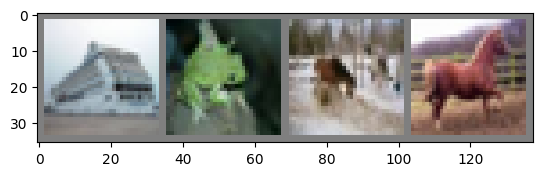

ship frog horse horse


In [6]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [7]:
# Подсмотрел идею тут https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super(BasicBlockNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.shortcut = nn.Conv2d(3, 32, kernel_size=1)
        self.avgpool = nn.AvgPool2d(kernel_size=8)
        self.fc1 = nn.Linear(32 * 4 * 4, 512) 
        self.fc2 = nn.Linear(512, n_classes)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [8]:
net = BasicBlockNet()
net

BasicBlockNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (avgpool): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [9]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [11]:
net = net.to(device) # rtx 4060 laptop

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [12]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            y_pred = model(data)
            loss = F.cross_entropy(y_pred, target)

            loss_log.append(loss.item())

            acc_log.extend((torch.argmax(y_pred, dim=-1) == target).cpu().numpy())
            
    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        y_pred = model(data)

        loss = F.cross_entropy(y_pred, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
       
        loss_log.append(loss.item())

        acc_log.extend((torch.argmax(y_pred, dim=-1) == target).cpu().numpy())

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        #train_loss_log.extend(train_loss)
        #train_acc_log.extend(train_acc)
        
        # Это нужно для красивого графика по заданию ниже
        train_loss_log.append(np.mean(train_loss))
        train_acc_log.append(np.mean(train_acc))

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")

        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [13]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.4825652007428993, train acc: 0.46625714285714287
 val loss: 1.2482415392043742, val acc: 0.5557333333333333

Epoch 1
 train loss: 1.1782782784981527, train acc: 0.5835142857142858
 val loss: 1.1773147200016265, val acc: 0.5979333333333333

Epoch 2
 train loss: 1.0819144102947367, train acc: 0.6222285714285715
 val loss: 1.1402004749216932, val acc: 0.6056

Epoch 3
 train loss: 1.037219033598682, train acc: 0.6377142857142857
 val loss: 1.0039411433199619, val acc: 0.6519333333333334

Epoch 4
 train loss: 1.0021906954932693, train acc: 0.6500285714285714
 val loss: 0.9804739916578252, val acc: 0.658

Epoch 5
 train loss: 0.9776343091968208, train acc: 0.6570571428571429
 val loss: 0.9819344812251152, val acc: 0.6642666666666667

Epoch 6
 train loss: 0.9507770478398534, train acc: 0.6651428571428571
 val loss: 0.9721200849147553, val acc: 0.6644

Epoch 7
 train loss: 0.9353831062805065, train acc: 0.6746571428571428
 val loss: 0.9570333465616754, val acc: 0.6684

E

Посчитайте точность на тестовой выборке:

In [14]:
def testAccuracy(model, test_data):
    model = model.eval()
    loss_log = []
    acc_log = []

    with torch.no_grad():
        for data, target in test_data:
            data, target = data.to(device), target.to(device)
            y_pred = model(data)
            loss = F.cross_entropy(y_pred, target)
            
            loss_log.append(loss.item())

            acc_log.extend((torch.argmax(y_pred, dim=-1) == target).cpu().numpy())
            
    return np.mean(loss_log), np.mean(acc_log)

test_loss, test_accuracy = testAccuracy(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_accuracy}")

 test loss: 0.9127130599538232, test acc: 0.6833


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

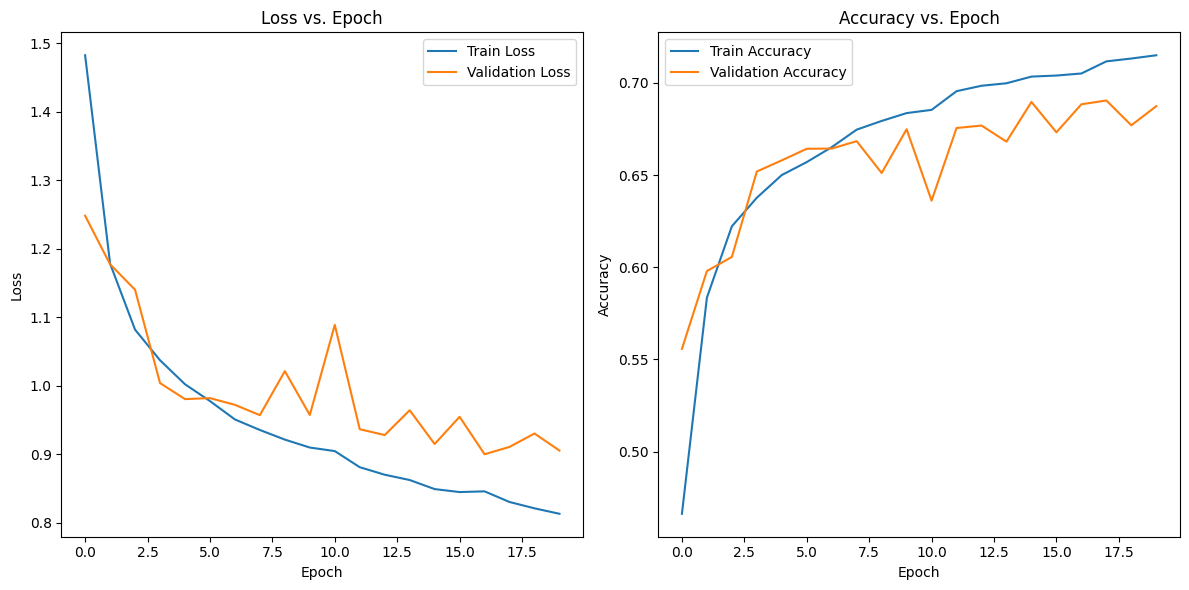

In [16]:
# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss_log, label='Train Loss')
plt.plot(val_loss_log, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_log, label='Train Accuracy')
plt.plot(val_acc_log, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.tight_layout()
plt.show()

## 3. Расписание длины шага (2 балла)

С первой недели модуля Вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [17]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.502648931752611, train acc: 0.4572857142857143
 val loss: 1.2698249910740143, val acc: 0.5527333333333333

Epoch 1
 train loss: 1.193115964777073, train acc: 0.5812571428571428
 val loss: 1.0934830348542397, val acc: 0.6206

Epoch 2
 train loss: 1.0958112413966024, train acc: 0.6177714285714285
 val loss: 1.1004586260369484, val acc: 0.6172666666666666

Epoch 3
 train loss: 1.042651822950548, train acc: 0.6358857142857143
 val loss: 1.1515024639190512, val acc: 0.6121333333333333

Epoch 4
 train loss: 1.0086047933785964, train acc: 0.6496
 val loss: 1.1679287357533232, val acc: 0.5872666666666667

Epoch 5
 train loss: 0.978132386203222, train acc: 0.6584571428571429
 val loss: 0.9783524419399018, val acc: 0.6608666666666667

Epoch 6
 train loss: 0.9631853039347493, train acc: 0.664
 val loss: 1.0333353811122001, val acc: 0.6344

Epoch 7
 train loss: 0.9412416851716678, train acc: 0.6740285714285714
 val loss: 1.0402740118351388, val acc: 0.6584666666666666

Epoch

Посчитайте точность на тестовой выборке:

In [19]:
test_loss, test_accuracy = testAccuracy(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_accuracy}")

 test loss: 0.84772424105626, test acc: 0.7171


**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [20]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.8707846115450537, train acc: 0.3455714285714286
 val loss: 1.6209331167505143, val acc: 0.4352

Epoch 1
 train loss: 1.5234112144606204, train acc: 0.4594285714285714
 val loss: 1.4236227451486791, val acc: 0.49193333333333333

Epoch 2
 train loss: 1.3905224938497247, train acc: 0.5073142857142857
 val loss: 1.349171268686335, val acc: 0.5254

Epoch 3
 train loss: 1.3123356135497364, train acc: 0.5345142857142857
 val loss: 1.2759098654097698, val acc: 0.5492

Epoch 4
 train loss: 1.2524397607477318, train acc: 0.5559714285714286
 val loss: 1.2192159305227563, val acc: 0.5666666666666667

Epoch 5
 train loss: 1.2047018636515197, train acc: 0.5780857142857143
 val loss: 1.1831230678456894, val acc: 0.5792

Epoch 6
 train loss: 1.1576371574314683, train acc: 0.5926285714285714
 val loss: 1.12695254569358, val acc: 0.5993333333333334

Epoch 7
 train loss: 1.1122836245043404, train acc: 0.6094571428571428
 val loss: 1.0762913701382089, val acc: 0.6209333333333333

Ep

In [21]:
test_loss, test_accuracy = testAccuracy(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_accuracy}")

 test loss: 0.9255609136478157, test acc: 0.6774


**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

In [22]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
# StepLR Уменьшает скорость обучения на фиксированный коэффициент (gamma) через заданное количество эпох (step_size).
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) # Уменьшает lr в 10 раз каждые 5 эпох
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.485095529931119, train acc: 0.4679142857142857
 val loss: 1.3983766124603596, val acc: 0.5061333333333333

Epoch 1
 train loss: 1.1885140159012413, train acc: 0.5835428571428571
 val loss: 1.2205485313496691, val acc: 0.5589333333333333

Epoch 2
 train loss: 1.1003343286418392, train acc: 0.6136
 val loss: 1.0975236712618077, val acc: 0.6244

Epoch 3
 train loss: 1.0395548632419522, train acc: 0.6382285714285715
 val loss: 1.014384570527584, val acc: 0.6451333333333333

Epoch 4
 train loss: 1.0093407646175712, train acc: 0.6498
 val loss: 1.0173240973594342, val acc: 0.6444666666666666

Epoch 5
 train loss: 0.8407653070019194, train acc: 0.7087714285714286
 val loss: 0.8932578429262689, val acc: 0.6932666666666667

Epoch 6
 train loss: 0.8154580567502017, train acc: 0.7184
 val loss: 0.8768057584762573, val acc: 0.6992666666666667

Epoch 7
 train loss: 0.8019313504425656, train acc: 0.7228
 val loss: 0.8689410683956552, val acc: 0.699

Epoch 8
 train loss: 0.7939

In [23]:
test_loss, test_accuracy = testAccuracy(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_accuracy}")

 test loss: 0.8556466041856511, test acc: 0.707


In [24]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
# ExponentialLR Уменьшает скорость обучения экспоненциально с течением времени.
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95) # Уменьшает lr на 5% каждую эпоху
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.5026215720220284, train acc: 0.4583714285714286
 val loss: 1.2328204020540765, val acc: 0.5638

Epoch 1
 train loss: 1.1906385386883667, train acc: 0.5807428571428571
 val loss: 1.106402316245627, val acc: 0.6098

Epoch 2
 train loss: 1.081879579824765, train acc: 0.6233142857142857
 val loss: 1.049700836425132, val acc: 0.6313333333333333

Epoch 3
 train loss: 1.0284731625638888, train acc: 0.6398571428571429
 val loss: 1.0110186987734855, val acc: 0.6532666666666667

Epoch 4
 train loss: 0.9815739663471034, train acc: 0.6556571428571428
 val loss: 1.0530448933865162, val acc: 0.6182

Epoch 5
 train loss: 0.9520013203786539, train acc: 0.6684285714285715
 val loss: 1.002212319729176, val acc: 0.6542666666666667

Epoch 6
 train loss: 0.9235305199893344, train acc: 0.6796857142857143
 val loss: 0.9607119760614761, val acc: 0.6668666666666667

Epoch 7
 train loss: 0.9036642448666763, train acc: 0.6855714285714286
 val loss: 0.9373593376037922, val acc: 0.6768666666

In [25]:
test_loss, test_accuracy = testAccuracy(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_accuracy}")

 test loss: 0.8799713318514976, test acc: 0.7006


Все способы уменьшения длины шага оказались эффективнее, чем статичный шаг (accuracy 0.68 со статичным и минимум 0.70 с уменьшением). Если сравнивать три способа ExponentialLR, StepLR и MultiStepLR, то:  
1 место - MultiStepLR (0.7171)  
2 место - StepLR (0.707)  
3 место - ExponentialLR (0.7006)  
Хотя может стоит еще поэксперементировать с коэфициентами этих способов

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

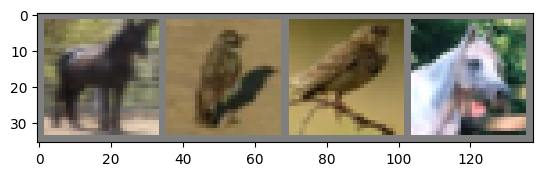

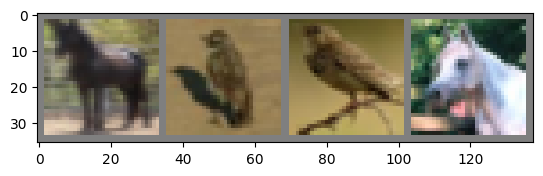

In [27]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [28]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.459702928061895, train acc: 0.47677142857142857
 val loss: 1.2722972172371885, val acc: 0.5488666666666666

Epoch 1
 train loss: 1.1847244115372682, train acc: 0.5802857142857143
 val loss: 1.1666717557196922, val acc: 0.6012

Epoch 2
 train loss: 1.1009027233289408, train acc: 0.6188857142857143
 val loss: 1.1120957737273358, val acc: 0.6212

Epoch 3
 train loss: 1.050706463387505, train acc: 0.6327142857142857
 val loss: 1.0559784123238096, val acc: 0.6346666666666667

Epoch 4
 train loss: 1.0142619433307125, train acc: 0.6461714285714286
 val loss: 0.9560869216918946, val acc: 0.664

Epoch 5
 train loss: 0.981863388413703, train acc: 0.659
 val loss: 0.9804767347396688, val acc: 0.6621333333333334

Epoch 6
 train loss: 0.9642209882492121, train acc: 0.6645428571428571
 val loss: 0.979051634352258, val acc: 0.6660666666666667

Epoch 7
 train loss: 0.9440233953692142, train acc: 0.6734
 val loss: 0.9123562465322779, val acc: 0.685

Epoch 8
 train loss: 0.9226222

Посчитайте точность на тестовой выборке:

In [29]:
test_loss, test_accuracy = testAccuracy(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_accuracy}")

 test loss: 0.8041482469078841, test acc: 0.7254


**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

In [31]:
# ColorJitterСлучайно изменяет яркость, контрастность, насыщенность и оттенок изображения

transform = transforms.Compose(
        [transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.5482389719874157, train acc: 0.4432857142857143
 val loss: 1.3206294901827549, val acc: 0.5278666666666667

Epoch 1
 train loss: 1.239776099948604, train acc: 0.5647428571428571
 val loss: 1.2284104014964814, val acc: 0.5767333333333333

Epoch 2
 train loss: 1.1523678449869592, train acc: 0.6006571428571429
 val loss: 1.1654711274390526, val acc: 0.5946666666666667

Epoch 3
 train loss: 1.0870498340352144, train acc: 0.6238285714285714
 val loss: 1.1412350697720304, val acc: 0.6058

Epoch 4
 train loss: 1.0588497492251492, train acc: 0.6310857142857142
 val loss: 1.0075858085713487, val acc: 0.6499333333333334

Epoch 5
 train loss: 1.0175436894244205, train acc: 0.646
 val loss: 1.0439843933633033, val acc: 0.6361333333333333

Epoch 6
 train loss: 0.9993525396971206, train acc: 0.6501714285714286
 val loss: 1.113115751236043, val acc: 0.6174666666666667

Epoch 7
 train loss: 0.9870982465404043, train acc: 0.6585428571428571
 val loss: 1.0200242747651769, val acc:

In [32]:
test_loss, test_accuracy = testAccuracy(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_accuracy}")

 test loss: 0.8447689398838456, test acc: 0.7119


In [33]:
# RandomRotation Случайно поворачивает изображение на угол в диапазоне от 5 до 25 градусов.

transform = transforms.Compose(
        [transforms.RandomRotation((5, 25)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.561774994817033, train acc: 0.43242857142857144
 val loss: 1.4961318685653362, val acc: 0.4700666666666667

Epoch 1
 train loss: 1.325352673665697, train acc: 0.5258571428571429
 val loss: 1.3139903479434074, val acc: 0.5249333333333334

Epoch 2
 train loss: 1.217621004559658, train acc: 0.5701714285714286
 val loss: 1.1617696959921655, val acc: 0.5846666666666667

Epoch 3
 train loss: 1.1500242703357606, train acc: 0.5938571428571429
 val loss: 1.2572488343462032, val acc: 0.5642666666666667

Epoch 4
 train loss: 1.1098962650656483, train acc: 0.6060857142857143
 val loss: 1.1003639173000417, val acc: 0.6139333333333333

Epoch 5
 train loss: 1.0765477242373898, train acc: 0.6200857142857142
 val loss: 1.0658285848637845, val acc: 0.6274

Epoch 6
 train loss: 1.0618141003674955, train acc: 0.6251142857142857
 val loss: 1.1377965036858904, val acc: 0.6017333333333333

Epoch 7
 train loss: 1.0437471405679608, train acc: 0.6330857142857143
 val loss: 1.0667551355159

In [34]:
test_loss, test_accuracy = testAccuracy(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_accuracy}")

 test loss: 1.0130843653041086, test acc: 0.659


(сравнение будет с результатом обучения с уменьшением шага MultiStepLR и без аугментации) RandomHorizontalFlip увеличил accuracy с 0.7171 до 0.7254. ColorJitter практически не оказал эффекта с 0.7171 до 0.7119 (значит цвета/яркость не оказывают такого сильного эффекта). А RandomRotation сильно ухудшил качество с 0.7171 до 0.659. Я думаю это связано с тем, что поворот изображения сильно искажает его, особенно если учитывать небольшой размер 32 х 32.

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [ ]:
# <your code here>